In [1]:
# Load required Libraries
%matplotlib inline
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import cv2
import os

In [15]:
# The discriminator model takes a sample image (from our dataset) as input and outputs a binary classification prediction.
# Input: 32 x 32 pixels 3 color channel (rgb) image [32,32,3]
# Output: Binary classification (0.0 to 1.0 - is it real or fake).

def define_discriminator(input_shape=(32,32,3)):
    model = keras.models.Sequential()
    # The discriminator is composed of a set convolutional layers, 
    # 1 normal convolutional layer followed by a set of 
    # 3 convolutional layers with a 2 x 2 stride. Together this layers 
    # Downsample the image from 32 x 32 x 3 all the way to 4 x 4 x 3.
    # Input is a 32*32*3 image
    model.add(keras.layers.Conv2D(filters=64,kernel_size= (3,3),padding = 'same',input_shape = input_shape))
    
    # The use of LeakyReLU, dropout and Adam as well as their 
    # parameters are derived from the documentation and good practices suggestions. 

    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.4))

    # Downsample 16*16*3 image
    model.add(keras.layers.Conv2D(filters= 128,kernel_size= (3,3),strides = (2,2),padding = 'same'))
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.4))
    
    # Downsample 8*8*3 image
    model.add(keras.layers.Conv2D(filters= 128,kernel_size= (4,4),strides = (2,2),padding = 'same'))
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.4))
    
    # Downsample 4*4*3
    model.add(keras.layers.Conv2D(filters= 256, kernel_size= (4,4), strides = (2,2), padding = 'same'))
    model.add(keras.layers.LeakyReLU(0.2))
    model.add(keras.layers.Dropout(0.4))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.4))

    # We have a single node in the output layer with 
    # sigmoid activation function for the prediction (real or fake)

    model.add(keras.layers.Dense(units= 1,activation = 'sigmoid'))
    opt = keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
    model.compile(loss= 'binary_crossentropy', optimizer= opt, metrics = ['accuracy'])
    
    return model

In [4]:
# The generator should output new fake images.
# It takes a point in the latent space as input and outputs a 32 x 32 rgb image.
# By assigning meaning to this latent points during the training process the latent space turns into a compressed repressentation of the dataset, generating "real" images.

# Input: Point in latent space
# Output: Rgb Image of 32 × 32 pixels (pixel values between -1 - 1)

def define_generator(latent_dim):
  # use a hidden dense layer to represent a low resolution version of the output (4 x 4 x 3).
  # Give enough nodes (256 - Arbitrary - can be changed) for multiple versions 
  # of the output image (more feature maps).
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(units= 256 * 4 * 4, input_dim = latent_dim)) #4 * 4 Arbitrary - Can be changed to test different results
    model.add(keras.layers.LeakyReLU(0.2)) # LeakyReLU with a default slope of 0.2, reported as a good practice. 
    model.add(keras.layers.Reshape((4, 4, 256)))
    # Pass the resulting feature maps into convolutional layer. 
    # Upsample the image to higher resolution.
    # Use Conv2DTranspose for upsampling with a stride of 2x2 
    # Repeat upsampling until achieving our 32 x 32 size goal.

    # Upsample 8 * 8 
    model.add(keras.layers.Conv2DTranspose(filters= 128, kernel_size = (4,4),padding='same', strides= (2,2)))
    model.add(keras.layers.LeakyReLU(0.2))
    # Upsample 16 * 16 
    model.add(keras.layers.Conv2DTranspose(filters= 128, kernel_size = (4,4),padding='same', strides= (2,2)))
    model.add(keras.layers.LeakyReLU(0.2))
    # Upsample  32 * 32 now
    model.add(keras.layers.Conv2DTranspose(filters= 128, kernel_size = (4,4),padding='same', strides= (2,2)))
    model.add(keras.layers.LeakyReLU(0.2))

    # Conv2D output layer with 3 filters (3 channels) with a kernel size of 3 
    # for generation of single feature map with preserved dimensions (32 x 32 x 3)
    # Use Than activation (good practice) to ensure the values are in range (from -1 to 1).
    model.add(keras.layers.Conv2D(filters= 3, kernel_size= (3,3),padding = 'same', activation= 'tanh')) 

    # the generated images are completely random pixel values in [-1, 1], rescaled to [0, 1].
    
    return model

In [5]:
# Generator weights are updated based in the discriminator performance. 
# The Gan function is defined to send the output from the generator to the discriminator, classified it, and then update generators weight. 
# Mark generator samples as real samples (trick discriminator)
# Discriminator is marked as not trainable (to avoid over trainning with fake samples).
def define_GAN(g_model, d_model):
    d_model.trainable = False
    model = keras.models.Sequential()
    model.add(g_model)
    model.add(d_model)
    opt = keras.optimizers.Adam(learning_rate= 0.0002,beta_1= 0.5)
    model.compile(loss= 'binary_crossentropy', optimizer= opt)
    return model

In [6]:
# Canadian Institute For Advanced Research dataset of 60,000 32 × 32 pixel color photographs of objects from 10 classes.
# https://www.cs.toronto.edu/~kriz/cifar.html
def load_data():
    (X_train, _), (_, _) = keras.datasets.cifar10.load_data()
    return X_train

In [7]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    X = np.random.randn(latent_dim * n_samples) # generate points in the latent space
    X = X.reshape((n_samples, latent_dim)) # reshape into a batch of inputs for the network
    return X

In [8]:
# select real samples
def generate_real_sample(n_samples):
    data = load_data() #we are loading the data withouth labels
    ix = np.random.randint(0,data.shape[0], n_samples)
    X = data[ix] # retrieve selected random images
    X = X.reshape((n_samples, 32, 32, 3)).astype('float32')
    X = (X - 127.5) / 127.5 # scale from [0,255] to [-1,1]
    y = np.ones((n_samples, 1)) # create real class labels
    return X, y

In [9]:
# use the generator to generate n fake examples, with class labels
def generate_fake_sample(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim= latent_dim,n_samples= n_samples)  # generate points in latent space
    X = g_model.predict(x_input) # predict outputs
    y = np.zeros((n_samples, 1)) # create class labels 
    return X, y

In [10]:
# create and save a plot of generated images
def save_plot(x_input, epoch, n=7):
    x_input = (x_input + 1.0) / 2.0
    filename = f'generated_{epoch + 1}.png'
    for i in range(n*n):
        plt.subplot(n, n, i+1)
        plt.imshow(x_input[i,:,:,:])
        plt.axis('off')
    plt.savefig(filename)
    plt.show()
    plt.close()

In [11]:
# Evaluate discriminator, plot generated images, save generator model
def summarize_the_model(g_model, d_model, epoch, latent_dim, n_samples):
    X_real, y_real = generate_real_sample(n_samples= n_samples)
    X_fake, y_fake = generate_fake_sample(g_model= g_model,
                                          latent_dim= latent_dim,
                                          n_samples= n_samples)
    print(f'Accuracy on real data: {d_model.evaluate(X_real, y_real, verbose= 0)}')
    print(f'Accuracy on fake data: {d_model.evaluate(X_fake, y_fake, verbose= 0)}')
    filename = f'model_e_{epoch + 1}.h5'
    save_plot(x_input= X_fake,
              epoch= epoch)
    
    g_model.save(filename)

In [13]:
# train the generator and discriminator
def train_GAN(gan_model, g_model, d_model, dataset_len, latent_dim, iters= 200, batch_size= 256):
    half_batch = int(batch_size / 2)
    batch_per_epoch = int(dataset_len / batch_size)
    for i in range(iters):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_sample(n_samples= half_batch)
            X_fake, y_fake = generate_fake_sample(g_model= g_model,
                                                  latent_dim= latent_dim,
                                                  n_samples= half_batch)
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_model.train_on_batch(X, y)
            
            x_gan = generate_latent_points(latent_dim= latent_dim,
                                             n_samples= batch_size)
            y_gan = np.ones((batch_size, 1))
            gan_model.train_on_batch(x_gan, y_gan)
            if not j%100: 
                print(f'Epoch: {i+1}, Batches/Epoch: {j+1}/{batch_per_epoch}')
                summarize_the_model(g_model= g_model,
                                    d_model= d_model,
                                    epoch= i,
                                    latent_dim= latent_dim,
                                    n_samples= batch_size)

Epoch: 1, Batches/Epoch: 1/195
Accuracy on real data: [0.6448764204978943, 1.0]
Accuracy on fake data: [0.6955575942993164, 0.0]


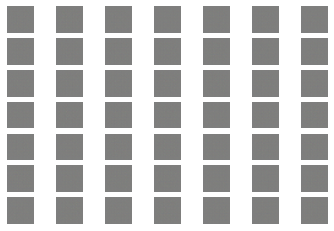

Epoch: 1, Batches/Epoch: 101/195
Accuracy on real data: [0.3208685517311096, 0.84765625]
Accuracy on fake data: [0.16625356674194336, 0.99609375]


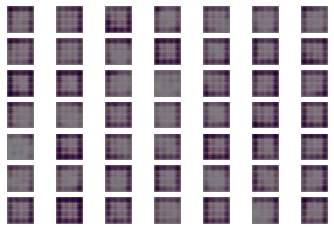

Epoch: 2, Batches/Epoch: 1/195
Accuracy on real data: [0.5984199643135071, 0.70703125]
Accuracy on fake data: [0.611320972442627, 0.73046875]


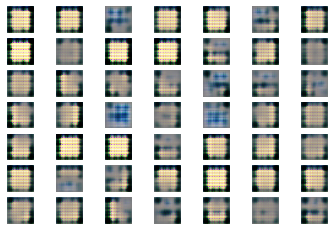

Epoch: 2, Batches/Epoch: 101/195
Accuracy on real data: [0.33740684390068054, 0.87890625]
Accuracy on fake data: [0.49198487401008606, 0.85546875]


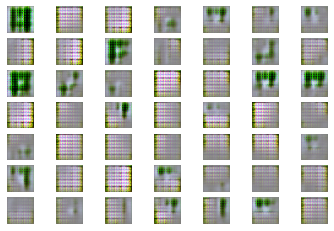

Epoch: 3, Batches/Epoch: 1/195
Accuracy on real data: [0.5538886785507202, 0.65625]
Accuracy on fake data: [0.40266552567481995, 0.94921875]


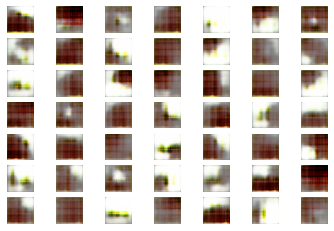

Epoch: 3, Batches/Epoch: 101/195
Accuracy on real data: [0.5085771679878235, 0.765625]
Accuracy on fake data: [0.5469480156898499, 0.78125]


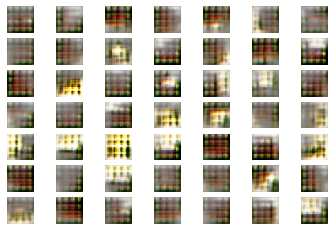

Epoch: 4, Batches/Epoch: 1/195
Accuracy on real data: [0.4584360420703888, 0.8671875]
Accuracy on fake data: [0.4479636251926422, 0.87890625]


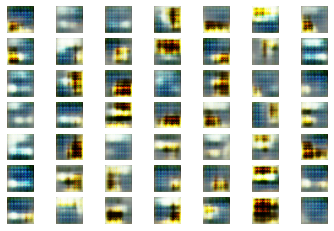

Epoch: 4, Batches/Epoch: 101/195
Accuracy on real data: [0.541992723941803, 0.6875]
Accuracy on fake data: [0.5515637993812561, 0.703125]


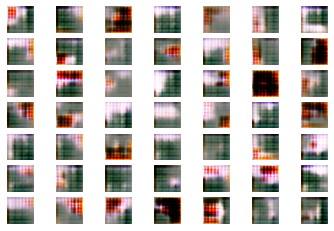

Epoch: 5, Batches/Epoch: 1/195
Accuracy on real data: [0.44224870204925537, 0.8515625]
Accuracy on fake data: [0.4916331470012665, 0.92578125]


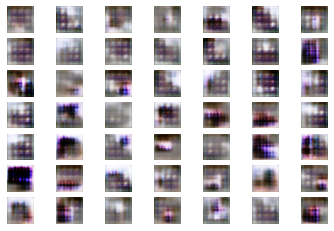

Epoch: 5, Batches/Epoch: 101/195
Accuracy on real data: [0.5982127785682678, 0.6171875]
Accuracy on fake data: [0.4406092166900635, 0.89453125]


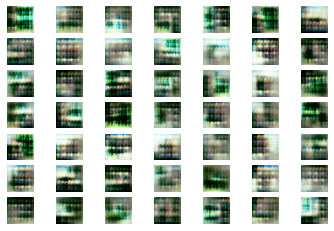

Epoch: 6, Batches/Epoch: 1/195
Accuracy on real data: [0.6740277409553528, 0.5546875]
Accuracy on fake data: [0.5847131609916687, 0.75390625]


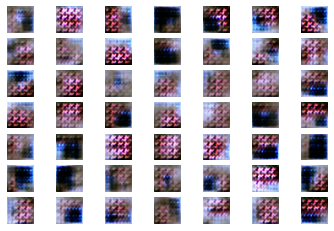

Epoch: 6, Batches/Epoch: 101/195
Accuracy on real data: [0.5780226588249207, 0.68359375]
Accuracy on fake data: [0.4600852429866791, 0.8984375]


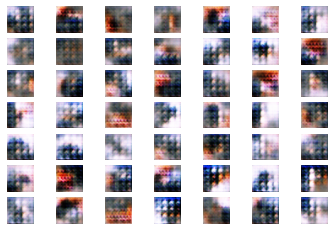

Epoch: 7, Batches/Epoch: 1/195
Accuracy on real data: [0.6618181467056274, 0.578125]
Accuracy on fake data: [0.6152439117431641, 0.65625]


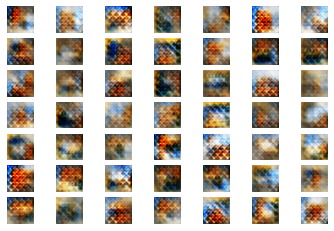

Epoch: 7, Batches/Epoch: 101/195
Accuracy on real data: [0.6637930274009705, 0.53515625]
Accuracy on fake data: [0.5988577008247375, 0.734375]


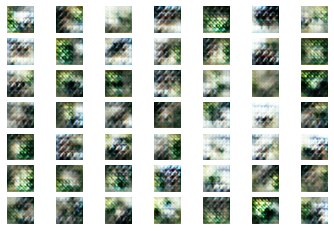

Epoch: 8, Batches/Epoch: 1/195
Accuracy on real data: [0.6969379186630249, 0.49609375]
Accuracy on fake data: [0.42342710494995117, 0.8984375]


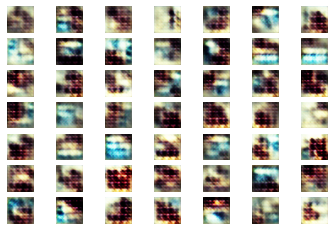

Epoch: 8, Batches/Epoch: 101/195
Accuracy on real data: [0.48203736543655396, 0.73828125]
Accuracy on fake data: [0.39129236340522766, 0.953125]


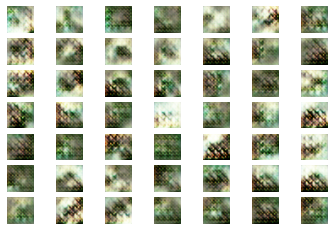

Epoch: 9, Batches/Epoch: 1/195
Accuracy on real data: [0.8488882184028625, 0.3828125]
Accuracy on fake data: [0.4575282037258148, 0.89453125]


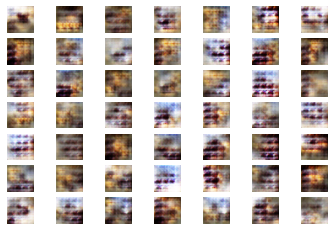

Epoch: 9, Batches/Epoch: 101/195
Accuracy on real data: [0.9742083549499512, 0.26171875]
Accuracy on fake data: [0.5067315697669983, 0.81640625]


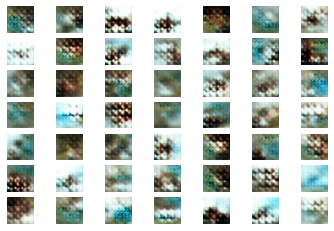

Epoch: 10, Batches/Epoch: 1/195
Accuracy on real data: [0.9228704571723938, 0.3125]
Accuracy on fake data: [0.48819005489349365, 0.85546875]


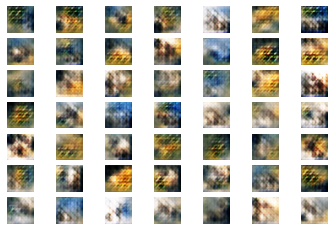

Epoch: 10, Batches/Epoch: 101/195
Accuracy on real data: [0.8054300546646118, 0.43359375]
Accuracy on fake data: [0.4633692502975464, 0.90625]


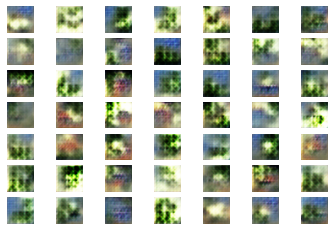

Epoch: 11, Batches/Epoch: 1/195
Accuracy on real data: [0.673971951007843, 0.55859375]
Accuracy on fake data: [0.5423305630683899, 0.8203125]


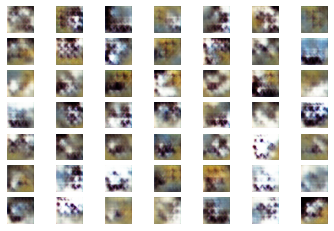

Epoch: 11, Batches/Epoch: 101/195
Accuracy on real data: [0.7544450163841248, 0.5078125]
Accuracy on fake data: [0.3278592526912689, 0.9765625]


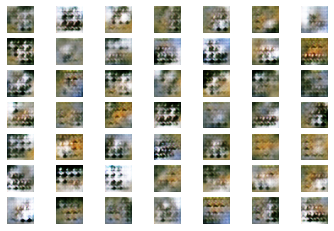

Epoch: 12, Batches/Epoch: 1/195
Accuracy on real data: [0.7153940200805664, 0.51171875]
Accuracy on fake data: [0.2438509166240692, 0.98828125]


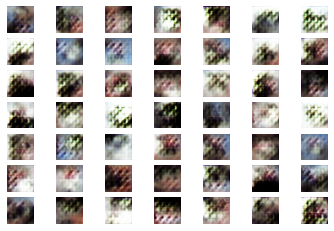

Epoch: 12, Batches/Epoch: 101/195
Accuracy on real data: [0.7772778272628784, 0.4453125]
Accuracy on fake data: [0.4292219877243042, 0.9296875]


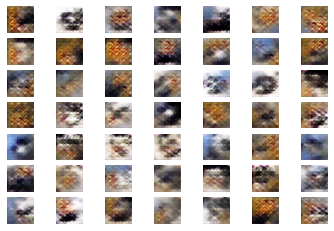

Epoch: 13, Batches/Epoch: 1/195
Accuracy on real data: [0.5690990090370178, 0.640625]
Accuracy on fake data: [0.260343462228775, 0.98828125]


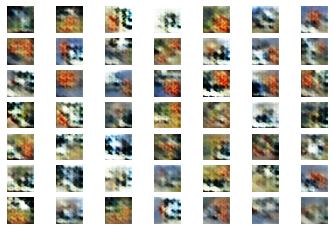

Epoch: 13, Batches/Epoch: 101/195
Accuracy on real data: [0.6879230737686157, 0.54296875]
Accuracy on fake data: [0.281741201877594, 0.94140625]


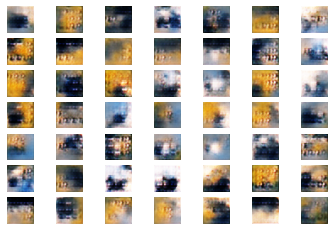

Epoch: 14, Batches/Epoch: 1/195
Accuracy on real data: [0.677808403968811, 0.58203125]
Accuracy on fake data: [0.24606481194496155, 0.98046875]


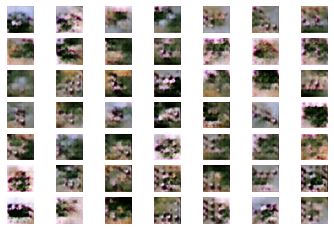

Epoch: 14, Batches/Epoch: 101/195
Accuracy on real data: [0.6829131841659546, 0.6015625]
Accuracy on fake data: [0.33192330598831177, 0.95703125]


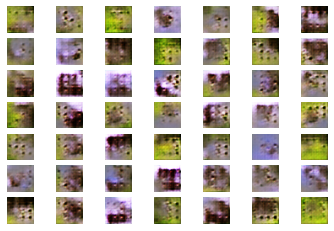

Epoch: 15, Batches/Epoch: 1/195
Accuracy on real data: [0.9882052540779114, 0.421875]
Accuracy on fake data: [0.2887515425682068, 0.9453125]


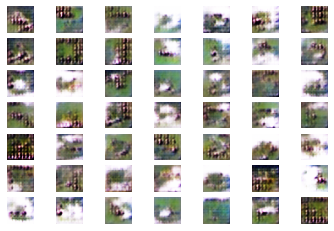

Epoch: 15, Batches/Epoch: 101/195
Accuracy on real data: [0.5657267570495605, 0.63671875]
Accuracy on fake data: [0.3892894685268402, 0.984375]


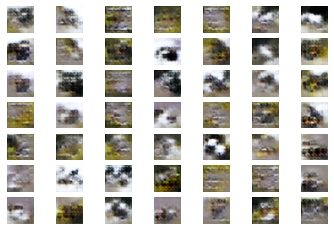

Epoch: 16, Batches/Epoch: 1/195
Accuracy on real data: [0.807845950126648, 0.42578125]
Accuracy on fake data: [0.35393714904785156, 0.95703125]


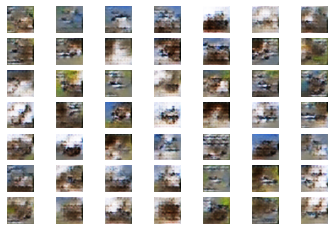

Epoch: 16, Batches/Epoch: 101/195
Accuracy on real data: [0.5630474090576172, 0.65625]
Accuracy on fake data: [0.20841389894485474, 1.0]


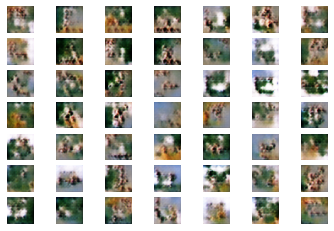

Epoch: 17, Batches/Epoch: 1/195
Accuracy on real data: [0.7075309157371521, 0.50390625]
Accuracy on fake data: [0.3440978229045868, 0.984375]


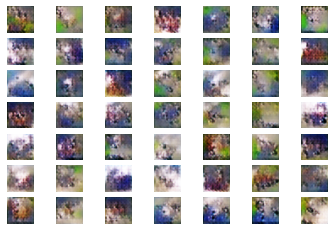

Epoch: 17, Batches/Epoch: 101/195
Accuracy on real data: [0.8948989510536194, 0.3515625]
Accuracy on fake data: [0.35203009843826294, 0.9453125]


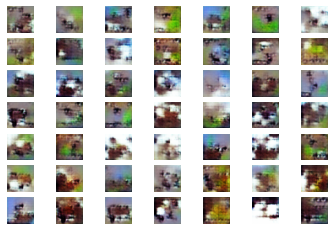

Epoch: 18, Batches/Epoch: 1/195
Accuracy on real data: [0.8589289784431458, 0.3671875]
Accuracy on fake data: [0.3903149962425232, 0.9609375]


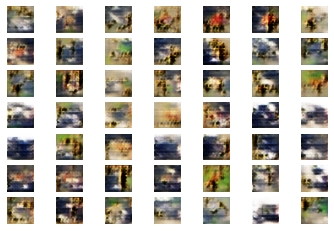

Epoch: 18, Batches/Epoch: 101/195
Accuracy on real data: [0.6366701126098633, 0.5546875]
Accuracy on fake data: [0.34596681594848633, 0.98828125]


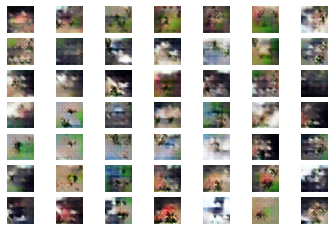

Epoch: 19, Batches/Epoch: 1/195
Accuracy on real data: [0.7807756066322327, 0.4296875]
Accuracy on fake data: [0.3956111669540405, 0.94921875]


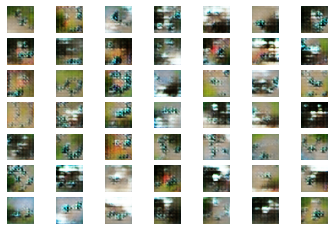

Epoch: 19, Batches/Epoch: 101/195
Accuracy on real data: [0.6450479030609131, 0.5859375]
Accuracy on fake data: [0.3272920250892639, 0.94140625]


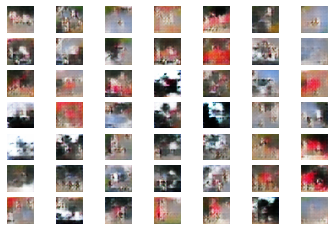

Epoch: 20, Batches/Epoch: 1/195
Accuracy on real data: [0.9121435284614563, 0.33984375]
Accuracy on fake data: [0.20610317587852478, 0.99609375]


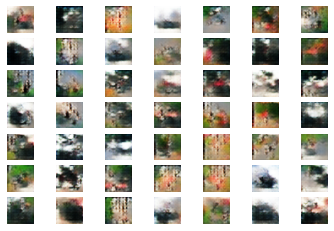

Epoch: 20, Batches/Epoch: 101/195
Accuracy on real data: [0.7602011561393738, 0.4609375]
Accuracy on fake data: [0.23022794723510742, 0.9921875]


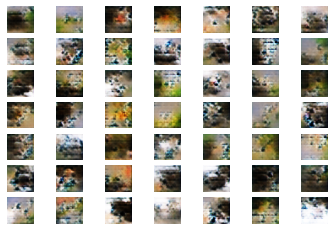

Epoch: 21, Batches/Epoch: 1/195
Accuracy on real data: [0.6978005170822144, 0.5]
Accuracy on fake data: [0.2607725262641907, 0.98046875]


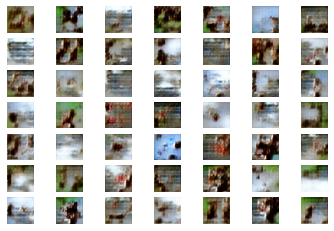

Epoch: 21, Batches/Epoch: 101/195
Accuracy on real data: [1.0082472562789917, 0.3046875]
Accuracy on fake data: [0.3042784631252289, 0.96484375]


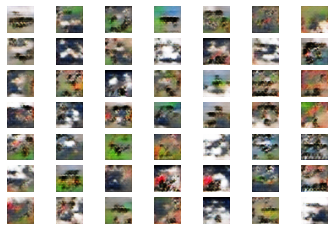

Epoch: 22, Batches/Epoch: 1/195
Accuracy on real data: [0.7550327777862549, 0.44140625]
Accuracy on fake data: [0.34184128046035767, 0.953125]


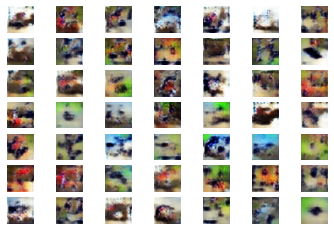

Epoch: 22, Batches/Epoch: 101/195
Accuracy on real data: [0.7854866981506348, 0.44140625]
Accuracy on fake data: [0.441661536693573, 0.90234375]


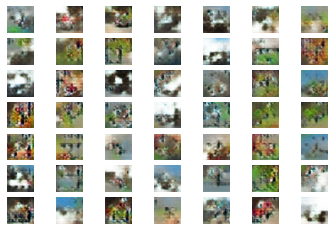

Epoch: 23, Batches/Epoch: 1/195
Accuracy on real data: [0.9006764888763428, 0.38671875]
Accuracy on fake data: [0.3726412057876587, 0.9375]


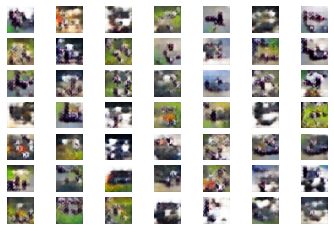

Epoch: 23, Batches/Epoch: 101/195
Accuracy on real data: [1.0168771743774414, 0.265625]
Accuracy on fake data: [0.2525568902492523, 0.984375]


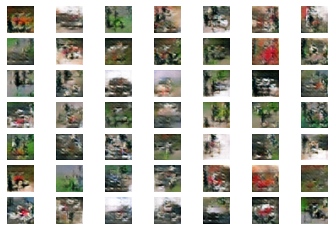

Epoch: 24, Batches/Epoch: 1/195
Accuracy on real data: [0.9779621362686157, 0.3203125]
Accuracy on fake data: [0.27557671070098877, 0.99609375]


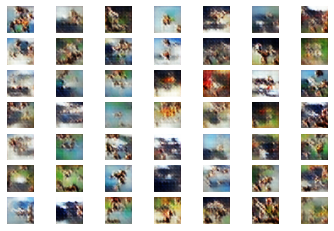

Epoch: 24, Batches/Epoch: 101/195
Accuracy on real data: [0.9452937841415405, 0.32421875]
Accuracy on fake data: [0.3233168125152588, 0.95703125]


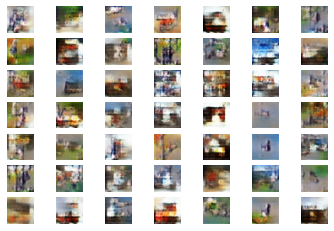

Epoch: 25, Batches/Epoch: 1/195
Accuracy on real data: [0.8287324905395508, 0.375]
Accuracy on fake data: [0.3214781880378723, 0.9921875]


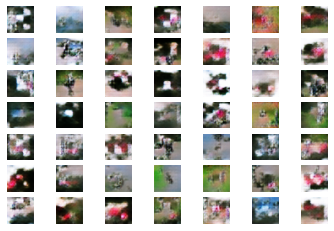

Epoch: 25, Batches/Epoch: 101/195
Accuracy on real data: [0.8849919438362122, 0.33203125]
Accuracy on fake data: [0.27639874815940857, 0.98828125]


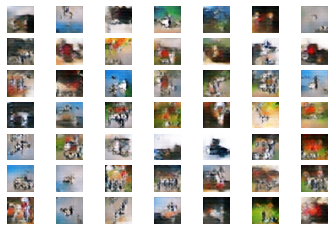

Epoch: 26, Batches/Epoch: 1/195
Accuracy on real data: [0.8965306282043457, 0.35546875]
Accuracy on fake data: [0.32525426149368286, 0.984375]


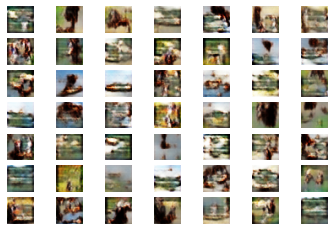

Epoch: 26, Batches/Epoch: 101/195
Accuracy on real data: [0.9278356432914734, 0.29296875]
Accuracy on fake data: [0.35500454902648926, 1.0]


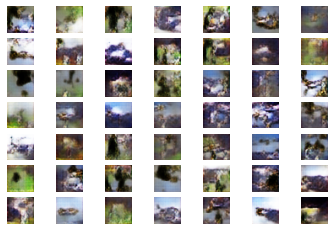

Epoch: 27, Batches/Epoch: 1/195
Accuracy on real data: [0.9401388764381409, 0.234375]
Accuracy on fake data: [0.3789512515068054, 0.99609375]


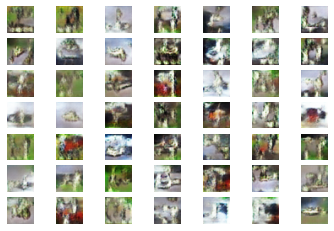

Epoch: 27, Batches/Epoch: 101/195
Accuracy on real data: [0.8290853500366211, 0.30859375]
Accuracy on fake data: [0.3580029308795929, 0.99609375]


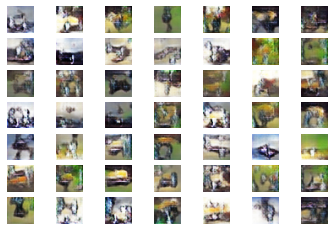

Epoch: 28, Batches/Epoch: 1/195
Accuracy on real data: [0.9284583926200867, 0.2265625]
Accuracy on fake data: [0.36098572611808777, 0.9921875]


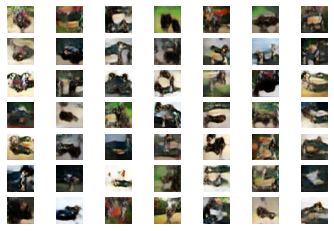

Epoch: 28, Batches/Epoch: 101/195
Accuracy on real data: [0.8430089950561523, 0.2421875]
Accuracy on fake data: [0.4271170496940613, 0.984375]


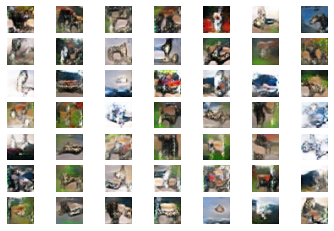

Epoch: 29, Batches/Epoch: 1/195
Accuracy on real data: [0.8145288228988647, 0.2734375]
Accuracy on fake data: [0.42689716815948486, 0.98828125]


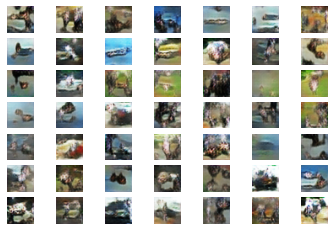

Epoch: 29, Batches/Epoch: 101/195
Accuracy on real data: [0.8666696548461914, 0.171875]
Accuracy on fake data: [0.44464972615242004, 0.9609375]


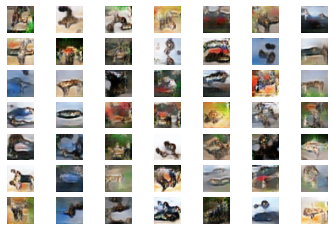

Epoch: 30, Batches/Epoch: 1/195
Accuracy on real data: [0.7981259822845459, 0.2734375]
Accuracy on fake data: [0.4553748071193695, 0.96484375]


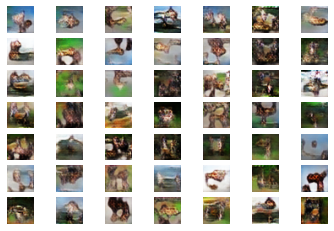

Epoch: 30, Batches/Epoch: 101/195
Accuracy on real data: [0.770913302898407, 0.328125]
Accuracy on fake data: [0.5082722306251526, 0.8984375]


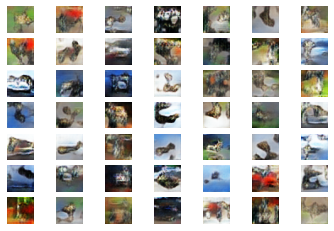

Epoch: 31, Batches/Epoch: 1/195
Accuracy on real data: [0.8122376203536987, 0.26953125]
Accuracy on fake data: [0.4935920238494873, 0.9375]


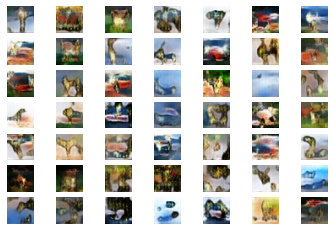

Epoch: 31, Batches/Epoch: 101/195
Accuracy on real data: [0.8575666546821594, 0.17578125]
Accuracy on fake data: [0.4411851167678833, 0.98046875]


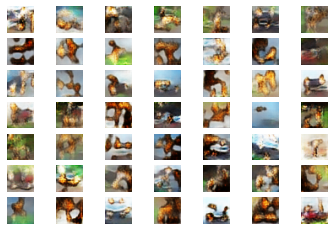

Epoch: 32, Batches/Epoch: 1/195
Accuracy on real data: [0.7622580528259277, 0.37890625]
Accuracy on fake data: [0.5321617126464844, 0.87109375]


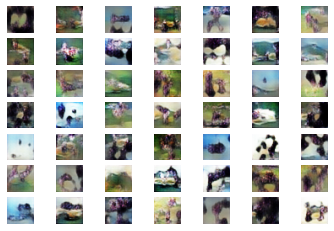

Epoch: 32, Batches/Epoch: 101/195
Accuracy on real data: [0.7768496870994568, 0.31640625]
Accuracy on fake data: [0.5121327042579651, 0.97265625]


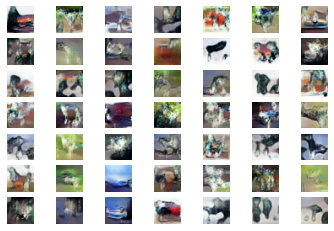

Epoch: 33, Batches/Epoch: 1/195
Accuracy on real data: [0.6750991344451904, 0.5625]
Accuracy on fake data: [0.5574499368667603, 0.8203125]


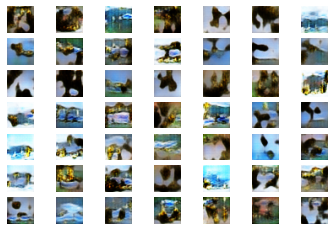

Epoch: 33, Batches/Epoch: 101/195
Accuracy on real data: [0.9331600069999695, 0.12109375]
Accuracy on fake data: [0.4256399869918823, 0.9921875]


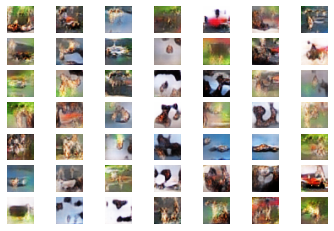

Epoch: 34, Batches/Epoch: 1/195
Accuracy on real data: [0.7370383739471436, 0.41015625]
Accuracy on fake data: [0.5342109203338623, 0.9140625]


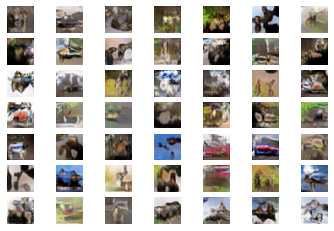

Epoch: 34, Batches/Epoch: 101/195
Accuracy on real data: [0.9248695373535156, 0.17578125]
Accuracy on fake data: [0.4709194302558899, 0.9609375]


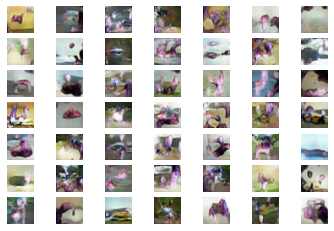

Epoch: 35, Batches/Epoch: 1/195
Accuracy on real data: [0.7967835664749146, 0.265625]
Accuracy on fake data: [0.4863373637199402, 0.9453125]


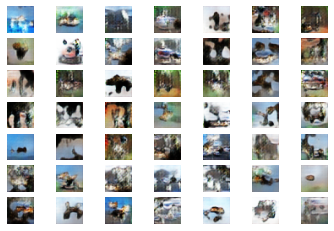

Epoch: 35, Batches/Epoch: 101/195
Accuracy on real data: [0.8898229598999023, 0.1796875]
Accuracy on fake data: [0.4211640954017639, 0.99609375]


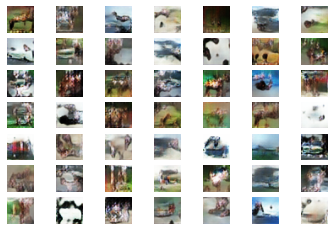

KeyboardInterrupt: 

In [16]:
# size of the latent space
latent_dim = 100
g_model = define_generator(latent_dim= latent_dim) 
d_model = define_discriminator()
gan_model = define_GAN(d_model= d_model,
                       g_model= g_model)
train_GAN(gan_model= gan_model, 
          g_model= g_model,
          d_model= d_model,
          dataset_len= load_data().shape[0],
          latent_dim= latent_dim)

In [19]:
# Load pretrained model 
model = keras.models.load_model('./model_e_34.h5', compile= False)

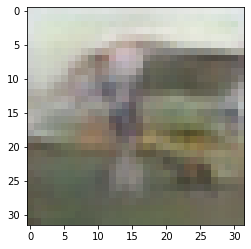

In [20]:
# Plot pre trained model prediction
vec = np.array([[np.cos(_) for _ in range(100)]])
X = ( model.predict(vec) + 1 ) / 2.0
plt.imshow(X[0])
plt.show()

In [21]:
# Define plotting for 49 image sample
def plotModel(model, n_samples=49):
    plt.figure(figsize=(18,9))
    for i in range(n_samples):
        ran = np.random.randn(n_samples, 100)
        sqrt = int(np.sqrt(n_samples))
        plt.subplot(sqrt, sqrt, i+1)
        X = model.predict(ran)
        X = (X + 1) / 2.0
        plt.imshow(X[0])
        plt.axis('off')
    plt.show()

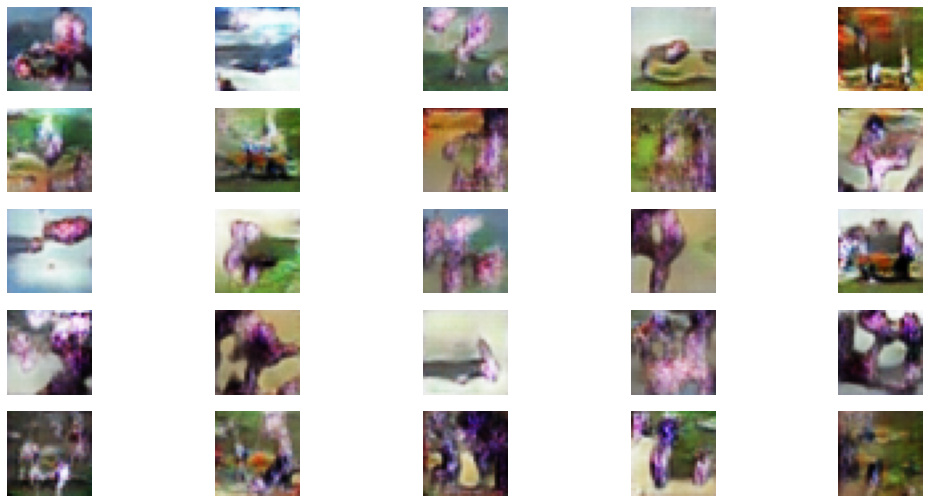

In [22]:
plotModel(model, n_samples= 25)

In [1]:
# GENERATING TRANSITION VIDEO